# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [39]:
from pathlib import Path

import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_tile_metadata, nd2_to_tiff
from lib.preprocess.file_utils import get_sample_fps

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [40]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "brieflow_output/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [41]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"

# paths to combo dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = "/Users/koppikarps/Development/ops/novaseq"
SBS_PATH_PATTERN = r"NovaSeqXTest_P(?P<plate>\d+)/Cycle(?P<cycle>\d+)/(?P<well>Well\d+)_Point\d+_(?P<tile>\d+)_Channel(?P<channel>[^_]+)_.*\.nd2"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "channel"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "cycle": int, "well": str, "tile": int, "channel": str}

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

## Create Sample DFs

In [42]:
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
sbs_wildcard_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
# Save and display sample dataframe
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)
sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
print("SBS wildcard combos:")
display(sbs_wildcard_combos)

SBS samples:


,sample_fp,plate,cycle,well,tile,channel
0,/Users/koppikarps/Development/ops/novaseq/Nova...,1,1,Well6,0,Cy3
1,/Users/koppikarps/Development/ops/novaseq/Nova...,1,1,Well6,0,DAPI
2,/Users/koppikarps/Development/ops/novaseq/Nova...,1,1,Well6,0,Far-red
3,/Users/koppikarps/Development/ops/novaseq/Nova...,1,1,Well6,0,GFP
4,/Users/koppikarps/Development/ops/novaseq/Nova...,1,2,Well6,0,Cy3
5,/Users/koppikarps/Development/ops/novaseq/Nova...,1,2,Well6,0,DAPI
6,/Users/koppikarps/Development/ops/novaseq/Nova...,1,2,Well6,0,Far-red
7,/Users/koppikarps/Development/ops/novaseq/Nova...,1,2,Well6,0,GFP
8,/Users/koppikarps/Development/ops/novaseq/Nova...,1,3,Well6,0,Cy3
9,/Users/koppikarps/Development/ops/novaseq/Nova...,1,3,Well6,0,DAPI


SBS wildcard combos:


,plate,cycle,well,tile,channel
0,1,1,Well6,0,Cy3
1,1,1,Well6,0,DAPI
2,1,1,Well6,0,Far-red
3,1,1,Well6,0,GFP
4,1,2,Well6,0,Cy3
5,1,2,Well6,0,DAPI
6,1,2,Well6,0,Far-red
7,1,2,Well6,0,GFP
8,1,3,Well6,0,Cy3
9,1,3,Well6,0,DAPI


## Test Metadata Extraction

In [43]:
if SBS_IMAGES_DIR_FP is not None:
    # Extract metadata from test sbs sample
    test_sbs_metadata = extract_tile_metadata(
        sbs_samples["sample_fp"][0],
        sbs_samples["plate"][0],
        sbs_samples["well"][0],
        sbs_samples["tile"][0],
        verbose=True,
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

Processing tile 0 from file /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelCy3_Seq4012.nd2
File shape: (2048, 2048)
Number of dimensions: 2
Data type: uint16
Sizes (by axes): {'Y': 2048, 'X': 2048}
SBS test metadata:


,x_pos,y_pos,z_pos,pfs_offset,plate,well,tile,filename,channels,pixel_size_x,pixel_size_y
0,117806.875,66745.864258,9082.64,None,1,Well6,0,/Users/koppikarps/Development/ops/novaseq/Nova...,1,0.65,0.65


## <font color='red'>SET PARAMETERS</font>

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [44]:
SBS_CHANNEL_ORDER = ["DAPI", "GFP", "Cy3", "Far-red"]

In [45]:
SBS_CHANNEL_ORDER_FLIP = None

## Test ND2 Conversion

### Test SBS conversion

Processing file 1/4: /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelDAPI_Seq2006.nd2
Original dimensions for /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelDAPI_Seq2006.nd2: ('Y', 'X')
Array shape after processing: (1, 2048, 2048)
Processing file 2/4: /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelGFP_1_Seq0000.nd2
Original dimensions for /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelGFP_1_Seq0000.nd2: ('Y', 'X')
Array shape after processing: (1, 2048, 2048)
Processing file 3/4: /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelCy3_Seq4012.nd2
Original dimensions for /Users/koppikarps/Development/ops/novaseq/NovaSeqXTest_P1/Cycle1/Well6_Point6_0000_ChannelCy3_Seq4012.nd2: ('Y', 'X')
Array shape after processing: (1, 2048, 2048)
Processing file 4/4: /Users/koppikarps/Developmen

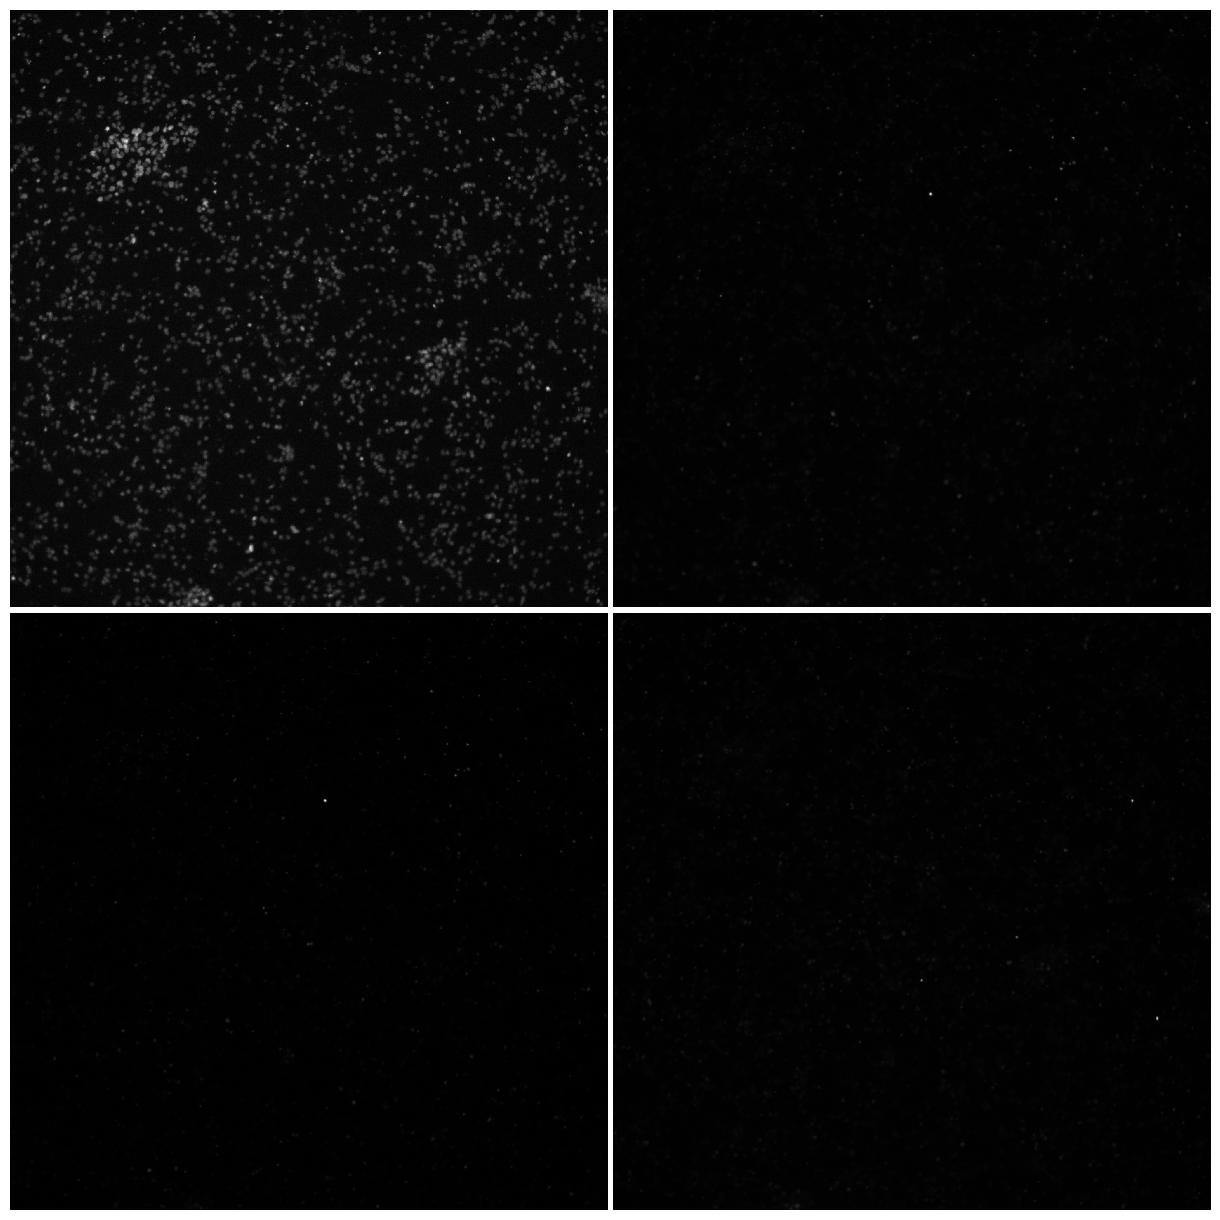

In [46]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        plate=sbs_samples["plate"][0],
        well=sbs_samples["well"][0],
        tile=sbs_samples["tile"][0],
        cycle=sbs_samples["cycle"][0],
        channel_order=SBS_CHANNEL_ORDER,
    )

    # Convert test sbs sample to tiff
    sbs_image = nd2_to_tiff(sbs_sample, SBS_CHANNEL_ORDER_FLIP, verbose=True)
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

### Test phenotype conversion

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [47]:
SAMPLE_FRACTION = 1.0

## Create config file with params

In [48]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)